In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, multinomial, beta, norm
from numpy.random import default_rng

# ------------ 1. Toy‑data generator (same setting as before) ------------
def generate_toy(seed=0):
    rng = default_rng(seed)
    K = 3
    n_sites = 60
    d = 3
    J_max = 10
    kappa_true = 0.3

    v_true = beta.rvs(1, 1, size=J_max, random_state=rng)
    phi_true = rng.uniform(0, 1, size=(J_max, d))
    theta_true = dirichlet.rvs([1] * K, size=J_max, random_state=rng)

    X = rng.uniform(0, 1, size=(n_sites, d))

    def kernel(x, phi):
        diff = x[:, None, :] - phi[None, :, :]
        return np.exp(-np.sum(diff**2, axis=-1) / (2 * kappa_true**2))

    psi = v_true[None, :] * kernel(X, phi_true)
    W = psi / psi.sum(axis=1, keepdims=True)

    z = np.array([rng.choice(J_max, p=W[i]) for i in range(n_sites)])
    N_i = rng.integers(30, 80, size=n_sites)
    Y = np.vstack([multinomial.rvs(N_i[i], theta_true[z[i]], random_state=rng)
                   for i in range(n_sites)])
    return X, Y, kappa_true, K

# ------------ 2. KSBP trainer (function from previous answer) ------------
def _gauss_kernel(x, phi, kappa):
    diff = x[:, None, :] - phi[None, :, :]
    return np.exp(-np.sum(diff**2, axis=-1) / (2.0 * kappa**2))

def _log_multinom(counts, probs):
    return np.sum(counts * np.log(probs + 1e-20), axis=-1)

def train_ddp(X, Y, *, N=None, kappa=0.3, gamma=1.0, alpha0=1.0,
              J_max=30, n_iter=500, burnin=100, thin=1,
              sigma_phi=0.05, sigma_v=0.4, seed=0):
    rng = default_rng(seed)
    n, d = X.shape
    K = Y.shape[1]
    if N is None:
        N = Y.sum(axis=1)

    phi   = rng.uniform(0, 1, size=(J_max, d))
    v     = beta.rvs(1, gamma, size=J_max, random_state=rng)
    theta = dirichlet.rvs([alpha0/K]*K, size=J_max, random_state=rng)
    z     = rng.integers(J_max, size=n)
    u     = rng.uniform(0, 0.5, size=n)

    store_phi = store_v = store_theta = None
    trace_k = []

    for it in range(n_iter):
        Kmat = _gauss_kernel(X, phi, kappa)
        psi  = v * Kmat
        cumprod = np.cumprod(1.0 - psi, axis=1)
        pi = psi.copy()
        pi[:, 1:] *= cumprod[:, :-1]

        # z update
        log_like = _log_multinom(Y[:, None, :], theta[None, :, :])
        log_post = np.log(pi + 1e-20) + log_like
        log_post -= log_post.max(axis=1, keepdims=True)
        p_iz = np.exp(log_post)
        p_iz /= p_iz.sum(axis=1, keepdims=True)
        z = np.array([rng.choice(J_max, p=p_iz[i]) for i in range(n)])

        # slice update
        u = rng.uniform(0, pi[np.arange(n), z])
        u_min = u.min()
        cum_w = np.cumsum(pi, axis=1)
        mask  = cum_w < (1 - u_min)
        L = int(mask.any(axis=0).sum()) + 1
        L = max(L, 3)
        L = min(L, J_max)
        active = slice(0, L)

        # theta update
        for h in range(L):
            y_sum = Y[z == h].sum(axis=0) if np.any(z == h) else np.zeros(K)
            theta[h] = rng.dirichlet(alpha0/K + y_sum)

        # v update (Beta)
        m = np.bincount(z, minlength=L)
        b = (u[:, None] < psi[:, active])
        r = np.array([(b[:, h] & (z > h)).sum() for h in range(L)])
        v[active] = beta.rvs(1 + m, gamma + r, random_state=rng)

        # phi MH
        for h in range(L):
            prop = phi[h] + rng.normal(scale=sigma_phi, size=d)
            if not ((prop >= 0).all() and (prop <= 1).all()):
                continue
            psi_h_old = psi[:, h].copy()
            psi_h_new = v[h] * _gauss_kernel(X, prop[None, :], kappa)[:, 0]
            psi_new = psi.copy()
            psi_new[:, h] = psi_h_new
            prod = np.prod(1 - psi_new[:, :h], axis=1)
            pi_old = psi[:, h] * prod
            pi_new = psi_new[:, h] * prod
            log_ratio = np.sum(np.log(pi_new[z == h] + 1e-20) -
                               np.log(pi_old[z == h] + 1e-20))
            if np.log(rng.uniform()) < log_ratio:
                phi[h] = prop
                psi[:, h] = psi_h_new

        # v MH (logit)
        for h in range(L):
            logit = np.log(v[h]) - np.log(1 - v[h])
            logit_prop = logit + rng.normal(scale=sigma_v)
            v_prop = 1 / (1 + np.exp(-logit_prop))
            log_prior = (beta.logpdf(v_prop, 1, gamma) -
                         beta.logpdf(v[h],   1, gamma))
            psi_h_new = v_prop * Kmat[:, h]
            prod = np.prod(1 - psi[:, :h], axis=1)
            pi_old = psi[:, h] * prod
            pi_new = psi_h_new * prod
            log_like_ratio = np.sum(np.log(pi_new[z == h] + 1e-20) -
                                    np.log(pi_old[z == h] + 1e-20))
            if np.log(rng.uniform()) < (log_prior + log_like_ratio):
                v[h] = v_prop
                psi[:, h] = psi_h_new

        trace_k.append(len(np.unique(z)))
        if (it >= burnin) and ((it - burnin) % thin == 0):
            store_phi, store_v, store_theta = phi.copy(), v.copy(), theta.copy()

    return dict(phi=store_phi, v=store_v, theta=store_theta,
                trace_clusters=np.array(trace_k))

# ------------ 3. Prediction helper -------------------------------------
def predict_pi_batch(x_new, result, kappa):
    phi = result['phi']; v = result['v']; theta = result['theta']
    Kmat = _gauss_kernel(x_new, phi, kappa)
    psi = v * Kmat
    cumprod = np.cumprod(1 - psi, axis=1)
    pi = psi.copy()
    pi[:, 1:] *= cumprod[:, :-1]
    pi_norm = pi / (pi.sum(axis=1, keepdims=True) + 1e-20)
    return pi_norm @ theta  # (n_new, K)

In [29]:
# ------------ 4. Run everything ----------------------------------------
X, Y, kappa_true, K = generate_toy(seed=0)

In [35]:
kappa_true

0.3

In [36]:
Y

array([[28,  0, 35],
       [24,  0, 17],
       [ 9, 51,  9],
       [19, 25, 13],
       [33,  0, 17],
       [16, 13,  1],
       [25,  0, 11],
       [37, 24,  4],
       [11, 32,  7],
       [45, 15,  5],
       [34, 38,  6],
       [ 5, 19, 38],
       [11, 51,  5],
       [13, 12, 35],
       [ 2, 39,  4],
       [11, 21,  1],
       [28, 30,  2],
       [14, 15, 13],
       [ 1, 16, 19],
       [25, 19, 14],
       [34, 25,  1],
       [23,  0, 26],
       [ 0, 34, 27],
       [11, 58, 10],
       [ 7, 21, 39],
       [35, 36,  5],
       [ 4, 11, 18],
       [23, 10,  4],
       [23, 21,  3],
       [34,  0, 25],
       [39,  1, 24],
       [12, 48,  4],
       [19, 48,  8],
       [ 5, 13, 18],
       [22,  0, 16],
       [ 6, 36,  3],
       [13, 15, 10],
       [12, 48,  5],
       [33, 13,  4],
       [ 4, 20, 51],
       [ 4, 17, 23],
       [ 1, 32, 14],
       [11, 22, 11],
       [ 9, 28,  4],
       [38,  0, 34],
       [15, 51,  5],
       [28, 14,  2],
       [15, 3

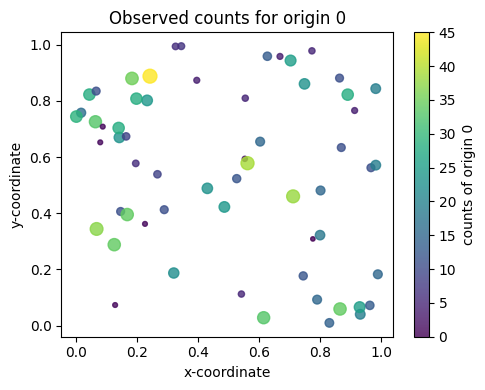

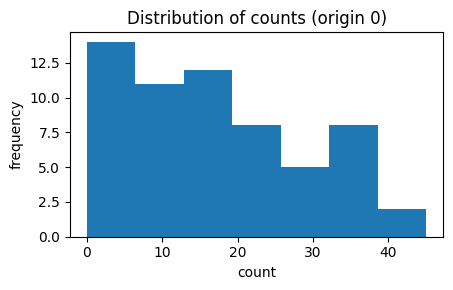

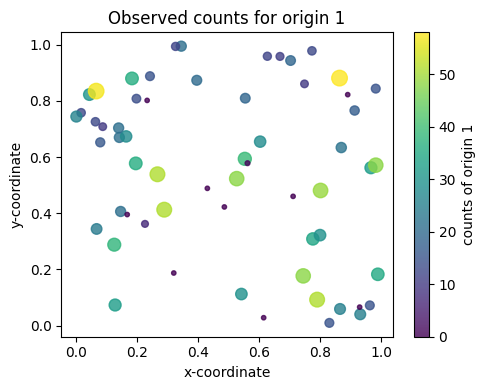

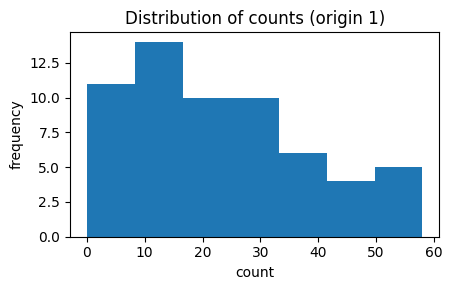

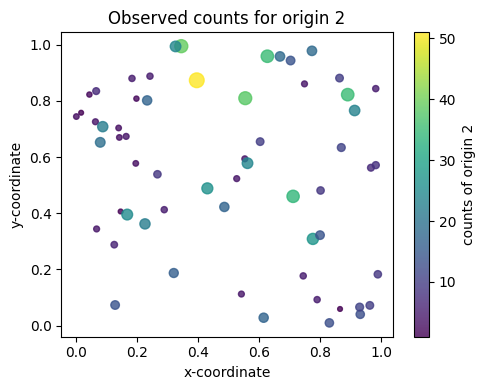

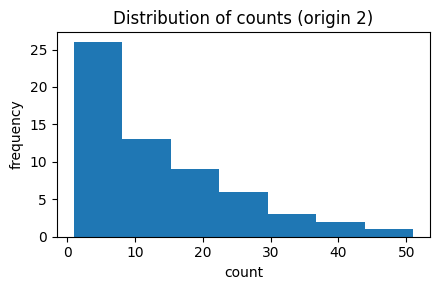

In [37]:

# -------------------------------
# 2. 可視化
# -------------------------------
for k in range(K):
    counts_k = Y[:, k]

    # ---- 2-1. 散布図 ----
    plt.figure(figsize=(5, 4))
    plt.scatter(
        X[:, 0], X[:, 1],
        c=counts_k,             # 色 = カウント
        s=10 + counts_k * 2,    # サイズ = カウントに比例（最小 10）
        alpha=0.8
    )
    plt.colorbar(label=f'counts of origin {k}')
    plt.title(f'Observed counts for origin {k}')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.tight_layout()
    plt.show()

    # ---- 2-2. ヒストグラム ----
    plt.figure(figsize=(4.5, 3))
    plt.hist(counts_k, bins='auto')
    plt.title(f'Distribution of counts (origin {k})')
    plt.xlabel('count')
    plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()


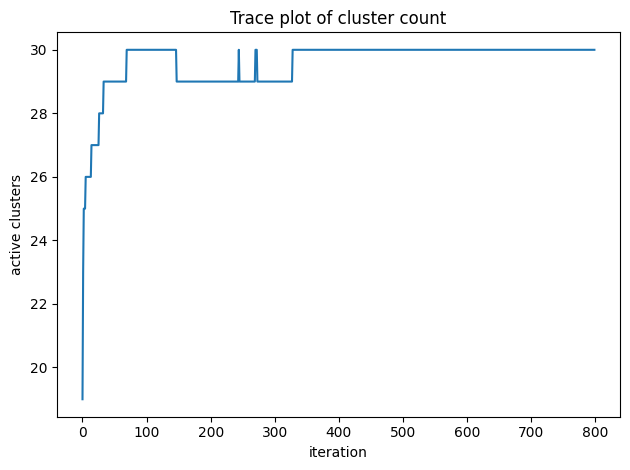

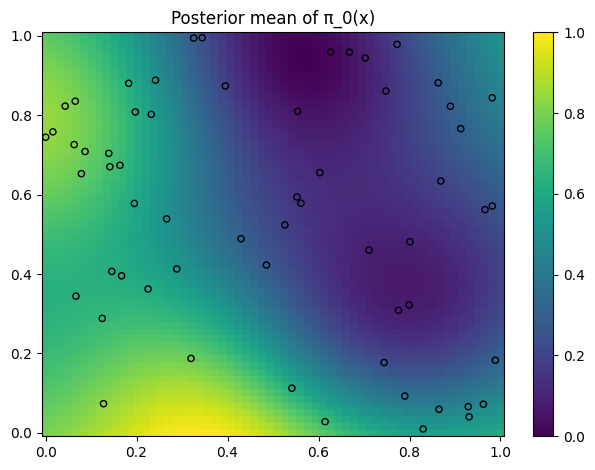

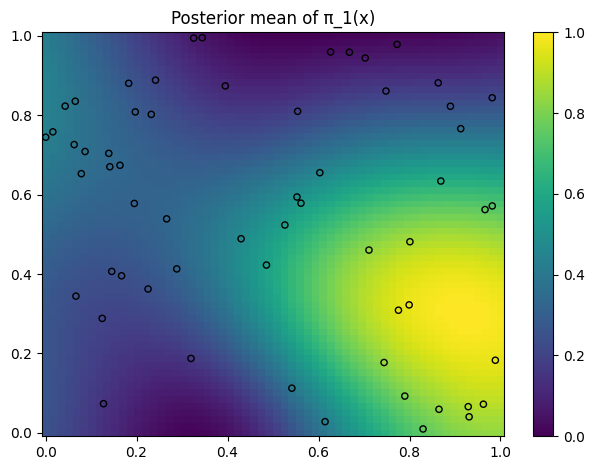

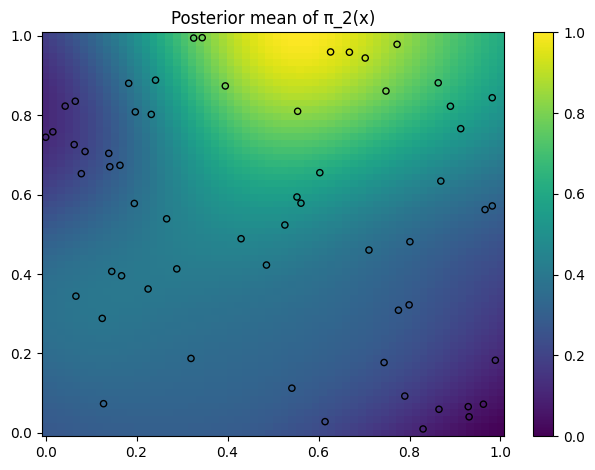

In [41]:
result = train_ddp(X, Y, kappa=0.05, n_iter=800, burnin=100, thin=1, seed=1)

# ---- trace plot ----
plt.figure()
plt.plot(result['trace_clusters'])
plt.xlabel('iteration')
plt.ylabel('active clusters')
plt.title('Trace plot of cluster count')
plt.tight_layout()
plt.show()

# ---- 2‑D posterior maps ----
grid_x, grid_y = np.meshgrid(np.linspace(0,1,60), np.linspace(0,1,60))
grid_env = 0.5*np.ones_like(grid_x)
grid = np.stack([grid_x.ravel(), grid_y.ravel(), grid_env.ravel()], axis=1)
pi_grid = predict_pi_batch(grid, result, kappa_true)  # (3600,K)

for k in range(K):
    plt.figure()
    plt.pcolormesh(grid_x, grid_y, pi_grid[:,k].reshape(grid_x.shape),
                   shading='auto')
    plt.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='k', s=20)
    plt.title(f'Posterior mean of π_{k}(x)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
